In [2]:
# HTML code to toggle code cell visibility
from IPython.display import HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/
jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="
javascript:code_toggle()"><input type="submit" 
value="Click here to toggle on/off the raw code."></form>
''')

In [3]:
# pip install nxviz
# pip install git+https://github.com/ericmjl/nxviz.git

---

<h1 style="color:#ff0090">[UPDATE]</h1>

---

*DASCI 272 - Network Science*

*Prepared by Erika G. Lacson*

#### Import Libraries and Packages

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.layout import multipartite_layout
import random

In [5]:
# colors
c_pink = 'ff0090'
c_green = '#04fc6c'
c_blue = '#0418fc'

# Display float values without scientific notation
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

--- 
<a id='Intro'></a>
<h1 style="color:#0494fc; background-color:#ffe6f4; border: 1px solid #ffffff; padding: 10px 0;">INTRODUCTION</h1>


- Start by explaining what network science is and how it can be applied to the field of international trade.
- Share why you chose to focus on the Philippine import-export industry.

--- 
<a id='Basics'></a>
<h1 style="color:#0494fc; background-color:#ffe6f4; border: 1px solid #ffffff; padding: 10px 0;">BACKGROUND AND BASICS</h1>

- Describe the Philippine economy and the role of import-export trade.
- Explain how import-export data can be represented as a network, with countries and product categories as nodes and trade values as edges.

--- 
<a id='Analysis'></a>
<h1 style="color:#0494fc; background-color:#ffe6f4; border: 1px solid #ffffff; padding: 10px 0;">ANALYSIS</h1>


- Analysis (in-depth)
- Perform EDA
- Visuals and graphs are expected
- Nice-to-have: exploring specific algorithms and network models in the context of the topic/phenomenon being explored
<br>


- EDA: Begin by performing exploratory data analysis. Use descriptive statistics and visualizations to give a broad overview of the data.
- Visuals and Graphs: Show the trade network graph, highlighting major nodes (countries and categories) and edges (trade values).
- Specific Algorithms and Models: Apply network analysis algorithms such as centrality measures to identify key players in the network. You can also discuss community detection algorithms to identify groups of closely connected nodes.

---

<h2 style="color:#0494fc; font-size:26px;">Network Representation</h2>

In using this dataset, I aim to obtain insights about the Philippines' 2022 imports and exports by Partner Country and by Chapter. Hence, the following summarizes my representation of this trade network:

<b><span style="color:#0494fc">NODES:</span></b>
- <b><span style="color:#ff0000">Reporter Country</span></b> - includes Philippines only, as I only want to analyze using the Philippines' point of view.
- <b><span style="color:#0418fc">Partner Countries</span></b> - includes partner countries with which the Philippines conducts import / export trade activities.
- <b><span style="color:#ff0090">Chapter</span></b> - represents product categories based on Harmonized System (HS) code. These are identification codes assigned to goods that are traded and recognized internationally.

<b><span style="color:#0494fc">EDGES:</span></b>
- Edges between the <b><span style="color:#ff0000">Reporter Country</span></b> and <b><span style="color:#0418fc">Partner Countries</span></b> represent trade interactions (imports and exports) weighted based on trade value in USD.
- Edges between <b><span style="color:#ff0000">Reporter Country</span></b> and <b><span style="color:#ff0090">Chapters</span></b> represent traded product categories (imported and exported product categories) weighted based on trade value in USD.

<b><span style="color:#0494fc">NETWORK TYPE:</span></b>
- This network will be a <b>directed</b> [the direction of the edges will represent the <i>imports</i> (pointing to the Philippines) and <i>exports</i> (pointing out of the Philippines), <b>weighted</b> (based on trade value in USD)], and <b>tripartite graph</b> (3 different nodes above, 1 same edge attribute based on trade value in USD).
</br>

---

<h2 style="color:#0494fc; font-size:26px;">Data Preparation</h2>

Before we begin with our analysis, let's load the data and prepare it for network analysis. 

In [6]:
def load_and_preprocess_data(filepath):    
    # Load the data
    df = pd.read_excel(filepath, header=0)
    
    # Update the data type of relevant columns
    df['HSCode'] = df['HSCode'].astype('object')
    df['Trade_Value_USD'] = df['Trade_Value_USD'].astype(float)
    
    # Check for missing rows (No missing rows) 
    missing_values = df.isna().sum().sum()
    display(HTML(f'<b>Number of missing values: {missing_values}\n</b>'))

    # Display the data types
    display(HTML(f'<b>Display data info:</b>'))
    display(df.info())

    # Display the data statistics
    display(HTML(f'<b>Display data statistics:</b>'))
    display(df.describe());

    return df

In [47]:
df = load_and_preprocess_data('PH_trades_2022.xlsx')

There are no missing values, data types are updated, and the trade values range from USD 25 to 9,022,178,907. Now that the data is clean and ready, we can proceed creating and visualizing the network. 

---

<h2 style="color:#0494fc; font-size:26px;">Network Creation and Visualization</h2>

We'll be using NetworkX library to represent our network. We'll start by creating a directed graph and adding the nodes and edges based on our `df` dataframe.

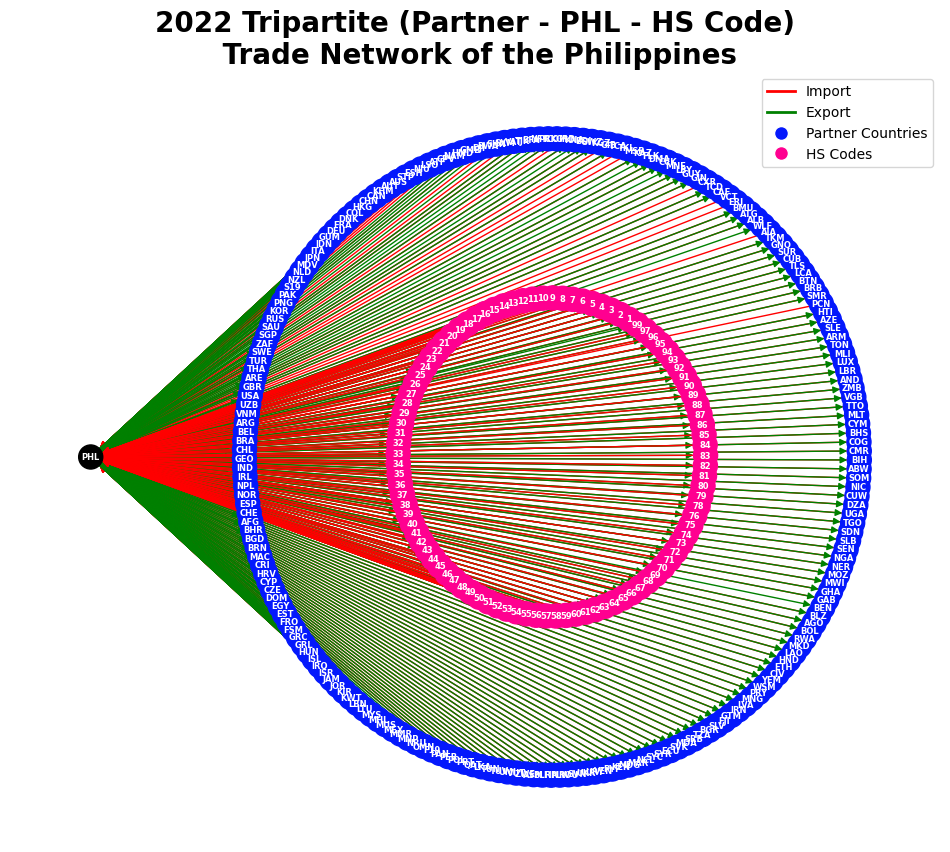

In [11]:
# Initialize a directed graph
G = nx.DiGraph()

# Add nodes
partner = df['PartnerISO'].unique()
reporter = df['ReporterISO'].unique()
chapter = df['HSCode'].unique()

G.add_nodes_from(partner, bipartite=0)
G.add_nodes_from(reporter, bipartite=1)
G.add_nodes_from(chapter, bipartite=2)

# Add edges
edges = []
for _, row in df.iterrows():
    if row['FlowDesc'] == 'Export':
        edges.append((row['ReporterISO'], row['PartnerISO'], {"weight": row['Trade_Value_USD'], "flow": "Export"}))
        edges.append((row['ReporterISO'], row['HSCode'], {"weight": row['Trade_Value_USD'], "flow": "Export"}))
    else:  # Import
        edges.append((row['PartnerISO'], row['ReporterISO'], {"weight": row['Trade_Value_USD'], "flow": "Import"}))
        edges.append((row['HSCode'], row['ReporterISO'], {"weight": row['Trade_Value_USD'], "flow": "Import"}))
G.add_edges_from(edges)

# Assign colors for edges based on the flow direction
edge_colors = ['green' if G[u][v]['flow'] == 'Export' else 'red' for u, v in G.edges()]

# Initialize color list
colors = []

# Assign colors for nodes
for node in G.nodes():
    if G.nodes[node]['bipartite'] == 0:  # partner nodes
        colors.append('#0418fc')
    elif G.nodes[node]['bipartite'] == 1:  # reporter nodes
        colors.append('#000000')
    else:  # chapter nodes
        colors.append('#ff0090')

# Visualization options
options = {
    "node_color": colors,
    "edge_color": edge_colors,
    "font_color": 'white',
    "with_labels": True,
    'font_size':6,
    'font_weight':'bold'
}

# Define the shell layout with three layers: PHL, partner countries, and chapters
shell_pos = nx.shell_layout(G, [list(chapter), list(partner), list(reporter)])

# Draw the graph using the shell layout with annotations
fig, ax = plt.subplots(figsize=(12, 10))
nx.draw(G, shell_pos, **options, ax=ax)

# Legend for edge colors and node groups
import_patch = plt.Line2D([0], [0], color="red", lw=2, label="Import")
export_patch = plt.Line2D([0], [0], color="green", lw=2, label="Export")
partner_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#0418fc', markersize=10, label='Partner Countries')
hscode_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff0090', markersize=10, label='HS Codes')
plt.legend(handles=[import_patch, export_patch, partner_patch, hscode_patch])

plt.title("2022 Tripartite (Partner - PHL - HS Code)\n Trade Network of the Philippines",
         fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.show()

### Illustrate Bipartite Networks separately.

#### 1. PHL - Partner Bipartite Network

In [12]:
df_partners = (df
               .copy()
               .drop(columns=['HSCode', 'Chapter'])
               .groupby(['FlowDesc', 'ReporterISO', 'PartnerISO', 'PartnerDesc'])
               .sum('Trade_Value_USD')
               .reset_index()
               .sort_values(by='Trade_Value_USD', ascending=False))

In [13]:
top_10_import_partners = df_partners[df_partners['FlowDesc']=='Import'][:10]
top_10_import_partners

,FlowDesc,ReporterISO,PartnerISO,PartnerDesc,Trade_Value_USD
239,Import,PHL,CHN,China,"29,796,347,043.00"
289,Import,PHL,IDN,Indonesia,"13,935,821,577.00"
299,Import,PHL,JPN,Japan,"13,086,141,586.00"
306,Import,PHL,KOR,Rep. of Korea,"12,730,035,481.00"
399,Import,PHL,USA,USA,"9,690,554,318.00"
365,Import,PHL,SGP,Singapore,"8,460,571,951.00"
384,Import,PHL,THA,Thailand,"7,656,411,913.00"
361,Import,PHL,S19,"Other Asia, nes","7,093,880,315.00"
335,Import,PHL,MYS,Malaysia,"6,680,522,080.00"
405,Import,PHL,VNM,Viet Nam,"4,773,472,579.00"


In [14]:
top_10_export_partners = df_partners[df_partners['FlowDesc']=='Export'][:10]
top_10_export_partners

,FlowDesc,ReporterISO,PartnerISO,PartnerDesc,Trade_Value_USD
192,Export,PHL,USA,USA,"12,476,937,774.00"
94,Export,PHL,JPN,Japan,"11,094,093,997.00"
36,Export,PHL,CHN,China,"10,965,840,327.00"
78,Export,PHL,HKG,"China, Hong Kong SAR","10,478,978,952.00"
160,Export,PHL,SGP,Singapore,"4,908,819,055.00"
178,Export,PHL,THA,Thailand,"3,374,362,655.00"
101,Export,PHL,KOR,Rep. of Korea,"3,127,015,016.00"
156,Export,PHL,S19,"Other Asia, nes","2,964,904,071.00"
136,Export,PHL,NLD,Netherlands,"2,941,094,285.00"
48,Export,PHL,DEU,Germany,"2,779,331,334.00"


**INSIGHTS:**

<b>Top 10 Import Partners</b>:

1. **Diversity in Geography:** Most of the top import partners are from Asia, particularly East and Southeast Asia (China, Indonesia, Japan, South Korea, Singapore, Thailand, Other Asia, Malaysia, and Vietnam). The USA is the only non-Asian country in the top import partners.
2. **Dominance of China:** China is by far the largest import partner, with trade values almost double that of the second largest partner, Indonesia. This suggests a significant dependence on China for imports.
3. **Balancing Act with USA:** Despite the dominance of Asian countries in the import list, the USA still stands as a significant trade partner for the Philippines, being the 5th largest source of imports.
4. **ASEAN Influence:** A significant portion of the imports come from ASEAN countries (Indonesia, Singapore, Thailand, Malaysia, and Vietnam). This underlines the importance of regional economic cooperation.


<b>Top 10 Export Partners</b>:

1. **USA and Japan Top the List:** The Philippines exports the most to the USA and Japan, with the trade values closely matched. This suggests a balanced trade relationship with both these major economies.
2. **China's Position:** China, being third, is also a significant destination for Filipino exports, but the Philippines imports more from China than it exports.
3. **Hong Kong's Role:** Interestingly, Hong Kong (SAR of China) stands out as a major export destination, possibly serving as a re-export hub for goods destined for mainland China and other parts of the world.
4. **European Presence:** The Netherlands and Germany appear in the top 10 export partners, indicating ties with the European market, especially for certain niche products or sectors.


In [15]:
# Bipartite Network for df_partners

# EXPORTS
exports_G = nx.DiGraph()
exports_G.add_node('PHL', bipartite=0)
exports_G.add_nodes_from(df_partners[df_partners['FlowDesc'] == 'Export']['PartnerISO'].unique(), bipartite=1)
for _, row in df_partners[df_partners['FlowDesc'] == 'Export'].iterrows():
    exports_G.add_edge('PHL', row['PartnerISO'], weight=row['Trade_Value_USD'])

# IMPORTS
imports_G = nx.DiGraph()
imports_G.add_node('PHL', bipartite=0)
imports_G.add_nodes_from(df_partners[df_partners['FlowDesc'] == 'Import']['PartnerISO'].unique(), bipartite=1)
for _, row in df_partners[df_partners['FlowDesc'] == 'Import'].iterrows():
    imports_G.add_edge(row['PartnerISO'], 'PHL', weight=row['Trade_Value_USD'])

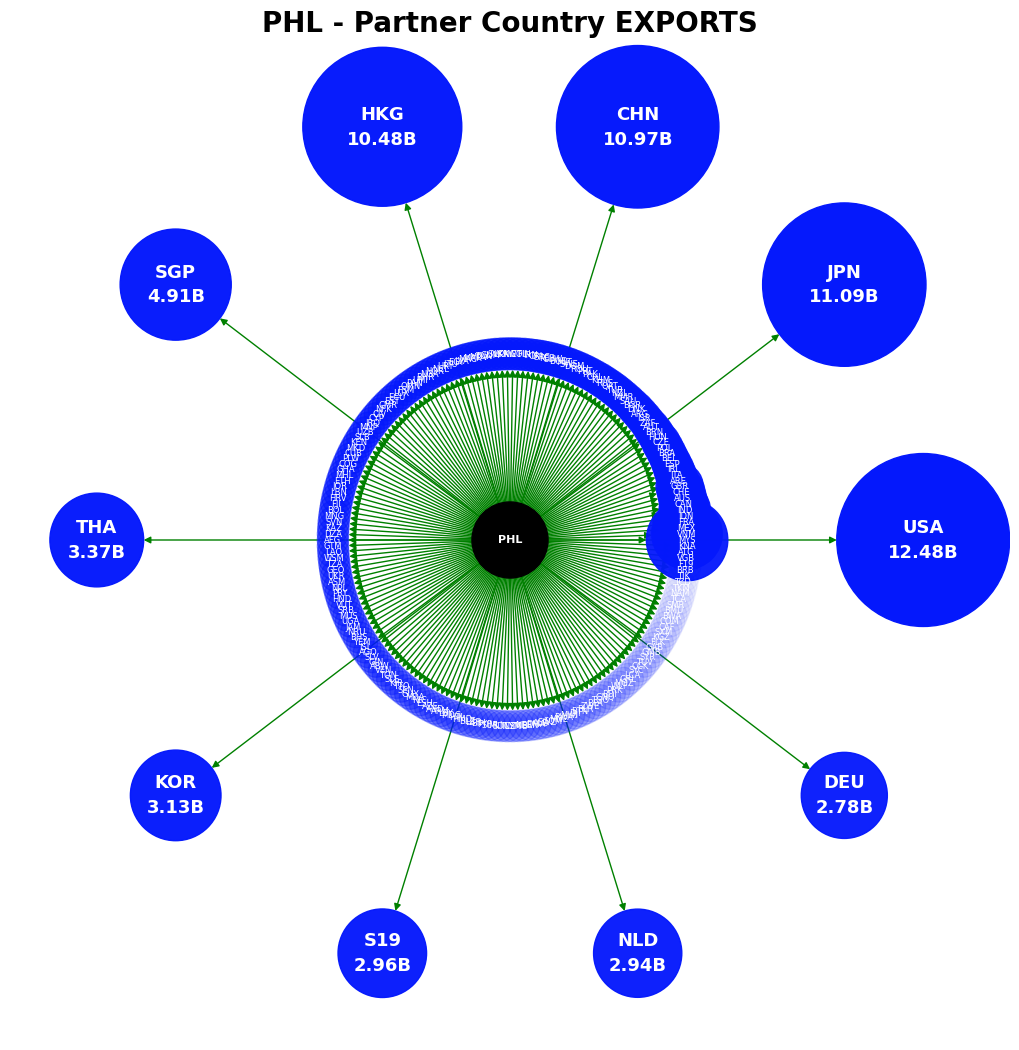

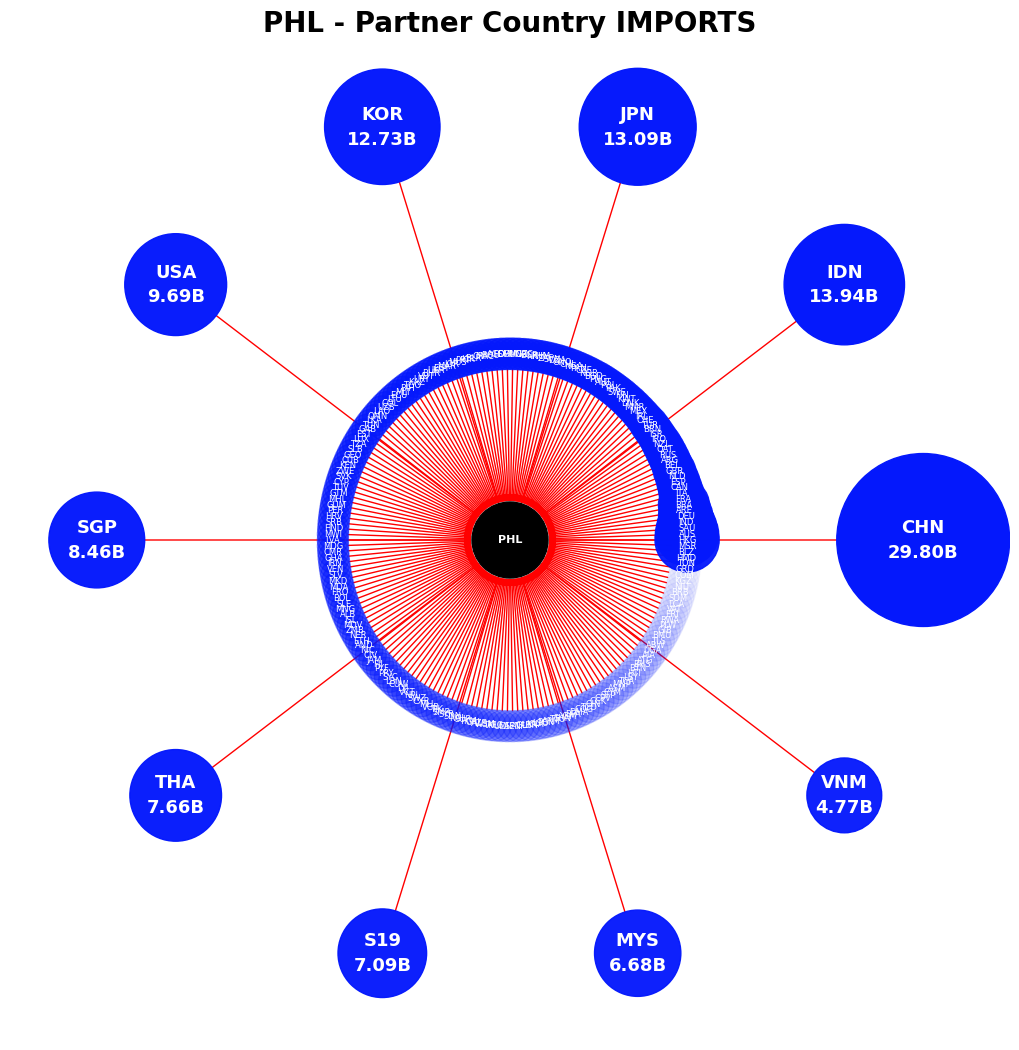

In [16]:
def visualize_bipartite_digraph_partners(graph, title, flow_desc):
    # Extract top 10 partners by trade value
    top_10_partners = df_partners[df_partners['FlowDesc'] == flow_desc].nlargest(10, 'Trade_Value_USD')['PartnerISO'].tolist()
    top_10_values = df_partners[df_partners['FlowDesc'] == flow_desc].nlargest(10, 'Trade_Value_USD')['Trade_Value_USD'].tolist()

    # Convert values to millions
    top_10_values_billions = [value / 1e9 for value in top_10_values]
    
    # Fixed positions for top 10 partners
    fixed_positions = {'PHL': (0, 0)}
    angle = np.linspace(0, 2 * np.pi, len(top_10_partners) + 1)
    radius_outer = 0.7  # Outer radius for top 10
    radius_inner = 0.3  # Inner radius for other nodes
    
    for idx, partner in enumerate(top_10_partners):
        fixed_positions[partner] = (radius_outer * np.cos(angle[idx]), radius_outer * np.sin(angle[idx]))
    
    # Positioning other nodes (not in top 10) in inner circle
    other_partners = [node for node in graph.nodes() if node not in top_10_partners and node != 'PHL']
    angle_inner = np.linspace(0, 2 * np.pi, len(other_partners) + 1)
    for idx, partner in enumerate(other_partners):
        fixed_positions[partner] = (radius_inner * np.cos(angle_inner[idx]), radius_inner * np.sin(angle_inner[idx]))
    
    fixed_nodes = list(fixed_positions.keys())
    pos = nx.spring_layout(graph, pos=fixed_positions, fixed=fixed_nodes, seed=143, k=0.2)
    
    # Weights for node sizes
    trade_values = [graph[u][v]['weight'] for u, v in graph.edges()]
    max_trade_value = max(trade_values)
    node_sizes = [3000]  # Fixed size for PHL
    node_sizes.extend([500 + 15000 * (value / max_trade_value) for value in trade_values])
    
    # Edge colors
    edge_colors = ['green' if u == 'PHL' else 'red' for u, v in graph.edges()]
    
    # Node colors - Fade in descending order of trade value using alpha
    sorted_trade_values = sorted(trade_values, reverse=False)
    base_color = np.array([4/255, 24/255, 252/255, 1])  # RGB for #0418fc
    node_colors = ['#000000']  # PHL
    for _, _, weight in graph.edges(data='weight'):
        index = sorted_trade_values.index(weight)
        alpha = (index + 1) / len(sorted_trade_values)
        faded_color = tuple(base_color * [1, 1, 1, alpha])
        node_colors.append(faded_color)
    
    # Visualization options
    options = {
        "node_color": node_colors,
        "edge_color": edge_colors,
        "node_size": node_sizes,
        "font_color": 'white',
        "with_labels": False,
        'font_size': 6,
        'font_weight': 'bold',
        'width': 1
    }
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(graph, pos, **options)
    
    # Add labels with trade values (in millions) and PartnerISO inside the nodes for top 10 partners
    for idx, partner in enumerate(top_10_partners):
        plt.text(pos[partner][0], pos[partner][1] + 0.02, f"{partner}", ha='center', va='center', color='white', fontsize=13, fontweight='bold')
        plt.text(pos[partner][0], pos[partner][1] - 0.02, f"{top_10_values_billions[idx]:,.2f}B", ha='center', va='center', color='white', fontsize=13, fontweight='bold')
    
    # Label other nodes (not in top 10)
    for partner in other_partners:
        plt.text(pos[partner][0], pos[partner][1], f"{partner}", ha='center', va='center', color='white', fontsize=6)

    # Always label PHL
    plt.text(pos['PHL'][0], pos['PHL'][1], "PHL", ha='center', va='center', color='white', fontsize=8, fontweight='bold')
    
    plt.title(title, fontdict={'fontsize':20, 'fontweight':'bold'})
    plt.show()

# Visualization for EXPORTS with switched positions for top 10 and other nodes, alpha-faded colors, trade values (in millions), and PartnerISO inside nodes
visualize_bipartite_digraph_partners(exports_G, "PHL - Partner Country EXPORTS", "Export")

# Visualization for IMPORTS with switched positions for top 10 and other nodes, alpha-faded colors, trade values (in millions), and PartnerISO inside nodes
visualize_bipartite_digraph_partners(imports_G, "PHL - Partner Country IMPORTS", "Import")


#### 2. PHL - Chapter Bipartite Network

In [17]:
df_chapters = (df
               .copy()
               .drop(columns=['PartnerISO', 'PartnerDesc'])
               .groupby(['FlowDesc', 'ReporterISO', 'HSCode', 'Chapter'])
               .sum('Trade_Value_USD')
               .reset_index()
               .sort_values(by='Trade_Value_USD', ascending=False))

In [18]:
top_10_import_chapters = df_chapters[df_chapters['FlowDesc']=='Import'][:10]
top_10_import_chapters

,FlowDesc,ReporterISO,HSCode,Chapter,Trade_Value_USD
180,Import,PHL,85,Electrical machinery and equipment and parts t...,"32,541,860,983.00"
123,Import,PHL,27,"Mineral fuels, mineral oils and products of th...","25,753,480,412.00"
179,Import,PHL,84,"Nuclear reactors, boilers, machinery and mecha...","11,840,307,138.00"
182,Import,PHL,87,Vehicles; other than railway or tramway rollin...,"8,780,581,737.00"
168,Import,PHL,72,Iron and steel,"5,230,252,977.00"
135,Import,PHL,39,Plastics and articles thereof,"4,576,231,860.00"
106,Import,PHL,10,Cereals,"4,328,545,826.00"
185,Import,PHL,90,"Optical, photographic, cinematographic, measur...","3,041,921,257.00"
119,Import,PHL,23,"Food industries, residues and wastes thereof; ...","2,791,434,492.00"
126,Import,PHL,30,Pharmaceutical products,"2,703,677,089.00"


In [19]:
top_10_export_chapters = df_chapters[df_chapters['FlowDesc']=='Export'][:10]
top_10_export_chapters

,FlowDesc,ReporterISO,HSCode,Chapter,Trade_Value_USD
83,Export,PHL,85,Electrical machinery and equipment and parts t...,"43,557,340,801.00"
82,Export,PHL,84,"Nuclear reactors, boilers, machinery and mecha...","7,275,288,819.00"
88,Export,PHL,90,"Optical, photographic, cinematographic, measur...","2,414,260,566.00"
73,Export,PHL,74,Copper and articles thereof,"2,270,022,773.00"
14,Export,PHL,15,Animal or vegetable fats and oils and their cl...,"2,200,123,191.00"
25,Export,PHL,26,"Ores, slag and ash","2,047,778,185.00"
7,Export,PHL,8,"Fruit and nuts, edible; peel of citrus fruit o...","1,916,998,574.00"
70,Export,PHL,71,"Natural, cultured pearls; precious, semi-preci...","1,322,957,466.00"
26,Export,PHL,27,"Mineral fuels, mineral oils and products of th...","1,237,849,102.00"
38,Export,PHL,39,Plastics and articles thereof,"1,109,943,550.00"


<b>Top 10 Imported Chapters</b>:

1. **Electronics and Machinery Dominate:** Electrical machinery and equipment (HS 85) and Nuclear reactors, boilers, machinery (HS 84) are the top imported categories. This suggests that the Philippines might be importing components for assembly or manufacturing, especially in the electronics sector.
2. **Energy Dependence:** The significant import value of mineral fuels and oils (HS 27) indicates the Philippines' reliance on external sources for energy needs.
3. **Vehicle Imports:** The high trade value for vehicles (HS 87) suggests a growing consumer market and perhaps limited domestic production capabilities.
4. **Agriculture vs. Industrialization:** The Philippines imports cereals (HS 10), but also exports fruits and nuts (HS 8). This might indicate a shift or diversification in agricultural practices or demand patterns.

<b>Top 10 Exported Chapters</b>:

1. **Electronics Export Powerhouse:** The dominant value of exported electrical machinery and equipment (HS 85) confirms the Philippines' role as a significant player in the global electronics supply chain.
2. **Value-Added Exports:** The export of machinery (HS 84) and optical equipment (HS 90) suggests the Philippines' capability in higher value-added manufacturing.
3. **Natural Resources:** The export categories of copper (HS 74), ores (HS 26), and pearls & precious stones (HS 71) indicate that the Philippines is tapping into its rich natural resources for trade.
4. **Agri-Exports:** The export of animal or vegetable fats and oils (HS 15) and fruits and nuts (HS 8) highlights the importance of the agricultural sector in the Philippines' export portfolio.

In summary, the Philippines demonstrates a balanced trade relationship with major global economies, with a significant emphasis on electronics and machinery in both imports and exports. The country also capitalizes on its natural resources and agricultural products for trade. Regional ties, especially within ASEAN, play a crucial role in its trade dynamics. The data also suggests areas where the country might aim to enhance domestic production capabilities, like energy and vehicles. 

Source: Analysis based on the provided data.

In [20]:
# Bipartite Network for df_chapters

# EXPORTS
exports_G_chapters = nx.DiGraph()
exports_G_chapters.add_node('PHL', bipartite=0)
exports_G_chapters.add_nodes_from(df_chapters[df_chapters['FlowDesc'] == 'Export']['HSCode'].unique(), bipartite=1)
for _, row in df_chapters[df_chapters['FlowDesc'] == 'Export'].iterrows():
    exports_G_chapters.add_edge('PHL', row['HSCode'], weight=row['Trade_Value_USD'])

# IMPORTS
imports_G_chapters = nx.DiGraph()
imports_G_chapters.add_node('PHL', bipartite=0)
imports_G_chapters.add_nodes_from(df_chapters[df_chapters['FlowDesc'] == 'Import']['HSCode'].unique(), bipartite=1)
for _, row in df_chapters[df_chapters['FlowDesc'] == 'Import'].iterrows():
    imports_G_chapters.add_edge(row['HSCode'], 'PHL', weight=row['Trade_Value_USD'])

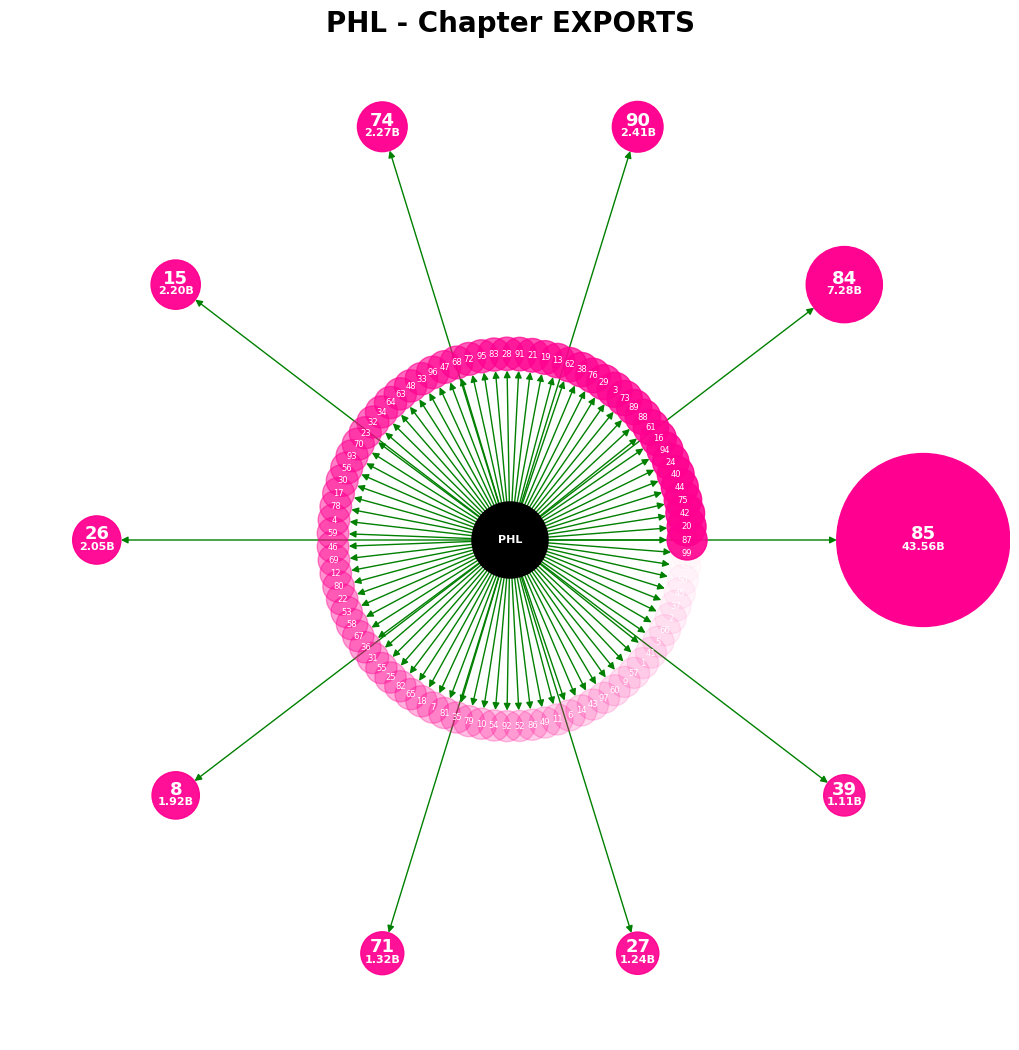

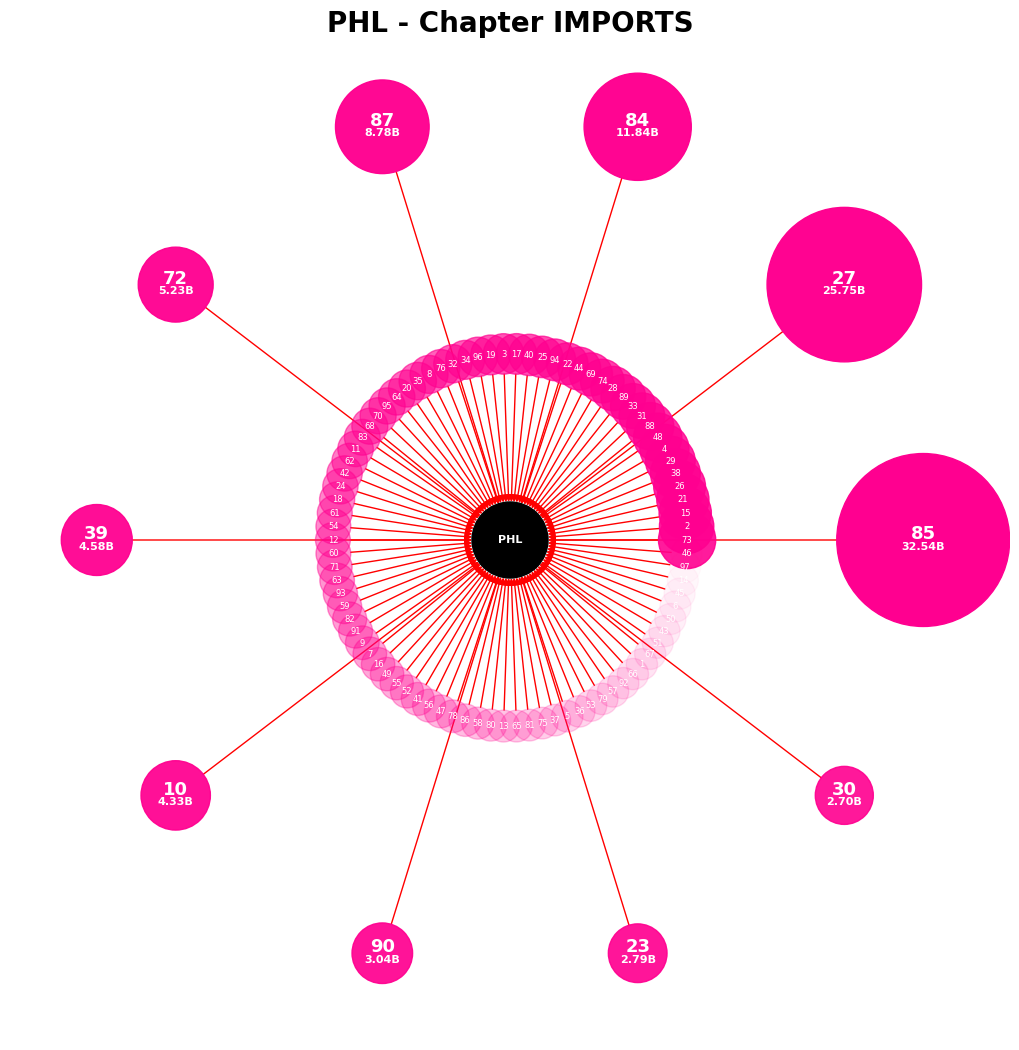

In [21]:
def visualize_bipartite_digraph_chapters(graph, title, flow_desc):
    # Extract top 10 chapters by trade value
    top_10_chapters = df_chapters[df_chapters['FlowDesc'] == flow_desc].nlargest(10, 'Trade_Value_USD')['HSCode'].tolist()
    top_10_values = df_chapters[df_chapters['FlowDesc'] == flow_desc].nlargest(10, 'Trade_Value_USD')['Trade_Value_USD'].tolist()

    # Convert values to billions
    top_10_values_billions = [value / 1e9 for value in top_10_values]
    
    # Fixed positions for top 10 chapters
    fixed_positions = {'PHL': (0, 0)}
    angle = np.linspace(0, 2 * np.pi, len(top_10_chapters) + 1)
    radius_outer = 0.7  # Outer radius for top 10
    radius_inner = 0.3  # Inner radius for other nodes
    
    for idx, chapter in enumerate(top_10_chapters):
        fixed_positions[chapter] = (radius_outer * np.cos(angle[idx]), radius_outer * np.sin(angle[idx]))
    
    # Positioning other nodes (not in top 10) in inner circle
    other_chapters = [node for node in graph.nodes() if node not in top_10_chapters and node != 'PHL']
    angle_inner = np.linspace(0, 2 * np.pi, len(other_chapters) + 1)
    for idx, chapter in enumerate(other_chapters):
        fixed_positions[chapter] = (radius_inner * np.cos(angle_inner[idx]), radius_inner * np.sin(angle_inner[idx]))
    
    fixed_nodes = list(fixed_positions.keys())
    pos = nx.spring_layout(graph, pos=fixed_positions, fixed=fixed_nodes, seed=143, k=0.2)
    
    # Weights for node sizes
    trade_values = [graph[u][v]['weight'] for u, v in graph.edges()]
    max_trade_value = max(trade_values)
    node_sizes = [3000]  # Fixed size for PHL
    node_sizes.extend([500 + 15000 * (value / max_trade_value) for value in trade_values])
    
    # Edge colors
    edge_colors = ['green' if u == 'PHL' else 'red' for u, v in graph.edges()]
    
    # Node colors - Fade in descending order of trade value using alpha
    sorted_trade_values = sorted(trade_values, reverse=False)
    base_color = np.array([255/255, 0/255, 144/255, 1])  # RGB for #ff0090
    node_colors = ['#000000']  # PHL
    for _, _, weight in graph.edges(data='weight'):
        index = sorted_trade_values.index(weight)
        alpha = (index + 1) / len(sorted_trade_values)
        faded_color = tuple(base_color * [1, 1, 1, alpha])
        node_colors.append(faded_color)
    
    # Visualization options
    options = {
        "node_color": node_colors,
        "edge_color": edge_colors,
        "node_size": node_sizes,
        "font_color": 'white',
        "with_labels": False,
        'font_size': 6,
        'font_weight': 'bold',
        'width': 1
    }
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(graph, pos, **options)
    
    # Add labels with trade values (in billions) and HSCode inside the nodes for top 10 chapters
    for idx, chapter in enumerate(top_10_chapters):
        plt.text(pos[chapter][0], pos[chapter][1] + 0.01, f"{chapter}", ha='center', va='center', color='white', fontsize=13, fontweight='bold')
        plt.text(pos[chapter][0], pos[chapter][1] - 0.01, f"{top_10_values_billions[idx]:,.2f}B", ha='center', va='center', color='white', fontsize=8, fontweight='bold')
    
    # Label other nodes (not in top 10)
    for chapter in other_chapters:
        plt.text(pos[chapter][0], pos[chapter][1], f"{chapter}", ha='center', va='center', color='white', fontsize=6)

    # Always label PHL
    plt.text(pos['PHL'][0], pos['PHL'][1], "PHL", ha='center', va='center', color='white', fontsize=8, fontweight='bold')
    
    plt.title(title, fontdict={'fontsize':20, 'fontweight':'bold'})
    plt.show()

# Visualization for EXPORTS for PHL-Chapter
visualize_bipartite_digraph_chapters(exports_G_chapters, "PHL - Chapter EXPORTS", "Export")

# Visualization for IMPORTS for PHL-Chapter
visualize_bipartite_digraph_chapters(imports_G_chapters, "PHL - Chapter IMPORTS", "Import")


---

<h2 style="color:#0494fc; font-size:26px;">Network Analysis</h2>

In [37]:
def network_stats(G, directed=True):
    """Printouts key Network Statistics."""
    # Network Statistics
    N = G.order()
    L = G.size()
    
    if directed:
        avg_deg = float(L) / N # if directed network
    else:
        avg_deg = 2*float(L) / N # if undirected network

    display(HTML(f'<b>Network Statistics:</b>'))
    print(f'    Nodes:          {N}')
    print(f'    Edges:          {L}')
    print(f'    Average degree: {avg_deg:.6f}')

In [38]:
G_eda = network_stats(G, directed=True)   

    Nodes:          319
    Edges:          605
    Average degree: 1.896552


In [50]:
df

In [40]:
nx.diameter(G)

NetworkXError: Found infinite path length because the digraph is not strongly connected

In [30]:
# Size and order
size = G.size()
order = G.order()

print(size)
print(order)

605
319


In [ ]:
# # Average degree
# average_degree = sum(dict(G.degree()).values()) / len(G)
# print(average_degree)

In [ ]:
# # Degree distribution
# degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
# degree_sequence

In [ ]:
# # Path lengths, distances, and diameter
# # Note: the network needs to be connected for these metrics to be meaningful
# try:
#     shortest_path = nx.shortest_path(G)
#     diameter = nx.diameter(G)
# except nx.NetworkXError:
#     print("The graph is not connected.")

# # Clustering coefficient
# # Note: the clustering coefficient is typically defined for undirected graphs
# clustering_coefficient = nx.average_clustering(nx.Graph(G))

# # Centrality measures
# degree_centrality = nx.degree_centrality(G)
# closeness_centrality = nx.closeness_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G)
# eigenvector_centrality = nx.eigenvector_centrality(G)

# # Community detection
# # Note: community detection is typically applied to undirected graphs
# communities = nx.community.greedy_modularity_communities(nx.Graph(G))


--- 
<a id='Insights'></a>
<h1 style="color:#0494fc; background-color:#ffe6f4; border: 1px solid #ffffff; padding: 10px 0;">INSIGHTS AND REFLECTION</h1>

- Discuss your findings from the analysis. This could include the most influential countries or product categories in the Philippine trade network.
- Reflect on how these insights could be applied, such as identifying potential markets for expansion or products for import substitution.

--- 
<a id='Conclusion'></a>
<h1 style="color:#0494fc; background-color:#ffe6f4; border: 1px solid #ffffff; padding: 10px 0;">CONCLUSION</h1>

- Summarize your findings and their potential applications.
- Discuss any limitations of your analysis and potential directions for future research.

#### e